In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [51]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [52]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h, _ = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [53]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(scores, y, net):
    acc = 0.0
    idxs = np.argmax(scores, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = np.sum(idxs == y_true)
    return acc / y.shape[0]

In [54]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test_fin = test_data['data']

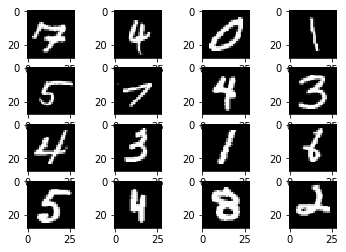

In [55]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Подготовка датасета

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.2, 
                                                    random_state=12, stratify=Y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=12)

In [57]:
mu = np.mean(X_train)
std = np.std(X_train)
eps = 1e-5

In [58]:
X_train = (X_train - mu) / (std + eps)
X_val = (X_val - mu) / (std + eps)
X_test = (X_test - mu) / (std + eps)
X_test_fin = (X_test_fin - mu) / (std + eps)

# Определение слоев сети

### affine_forward

In [59]:
def affine_forward(x, w, b):
    out = np.dot(x, w) + b
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    db = np.sum(dout, axis=0)
    dw = np.dot(x.T, dout)
    dx = np.dot(dout, w.T)
    return dx, dw, db

In [60]:
x = np.array([[1, 2, 3], [4, 5, 6]])
w = np.array([[1, 1], [1, 1], [1, 1]])
b = np.array([0.5, 0.4])
out, cachce = affine_forward(x, w, b)
dout = np.array([[1, 3], [1, 2]])
dx, dw, db = affine_backward(dout, cachce)

In [61]:
def relu_forward(x):
    out = np.maximum(0, x)
    cache = x
    return out, cache

def relu_backward(dout, cache):
    x = cache
    mask, _ = relu_forward(x)
    mask = mask > 0
    dout = dout * mask
    return dout

In [62]:
def dropout_forward(x, p=1):
    mask = (np.random.rand(*x.shape) < p) / p 
    out = x * mask
    cache = (p, mask)
    return out, cache

def dropout_backward(dout, cache):
    p, mask = cache
    dx = dout * mask
    return dx

In [63]:
def batchnorm_forward():
    pass

In [64]:
def cross_entropy(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    idxs = np.argmax(y, axis=1)
    loss = -np.sum(log_probs[np.arange(N), idxs]) / N
    dx = probs.copy()
    dx[np.arange(N), idxs] -= 1
    dx /= N
    return loss, dx

# Neuro Net

In [68]:
class MultiClassNet():
    
    def __init__(self, in_size, hidden_sizes, out_size, learning_rate=1e-4, prob=1, lr_decay=1):
        self.lr = learning_rate
        self.W = []
        self.b = []
        self.p = prob
        self.decay = lr_decay
        sizes = np.hstack((in_size, hidden_sizes, out_size))
        for i in range(len(sizes) - 1):
            in_size = sizes[i]
            out_size = sizes[i+1]
            w = np.random.normal(scale=1, size=[in_size, out_size]) * np.sqrt(2 / in_size)
            b = np.zeros(out_size)
            self.W.append(w)
            self.b.append(b)
       
    def forward(self, batch, mode='test'):
        cache_aff = []
        cache_relu = []
        cache_drout = []
        
        for n in range(len(self.W) - 1):
            batch, cur_aff_cache = affine_forward(batch, self.W[n], self.b[n])
            batch, cur_relu_cache = relu_forward(batch)
            if(mode == 'train'):
                batch, cur_drout_cache = dropout_forward(batch, self.p)
                cache_drout.append(cur_drout_cache)
            cache_aff.append(cur_aff_cache)
            cache_relu.append(cur_relu_cache)
       
        n += 1
        batch, cur_aff_cache = affine_forward(batch, self.W[n], self.b[n])
        cache_aff.append(cur_aff_cache)
        return batch, (cache_aff, cache_relu, cache_drout)
    
    
    def backward(self, dout, cache):
        lr = self.lr
        cache_aff, cache_relu, cache_drout = cache
        
        dout, dw, db = affine_backward(dout, cache_aff[-1])
        self.W[-1] = self.W[-1] - lr * dw
        self.b[-1] = self.b[-1] - lr * db
        
        for i in range(len(self.W) - 2, -1, -1):
            dout = dropout_backward(dout, cache_drout[i])
            dout = relu_backward(dout, cache_relu[i])
            dout, dw, db = affine_backward(dout, cache_aff[i])
            self.W[i] = self.W[i] - lr * dw
            self.b[i] = self.b[i] - lr * db
        
    def predict(self, x):
        scores, _ = self.forward(x)
        return scores 
    
    def train(self, x, y, x_val, y_val, batch_size=1, epoches=10):
        iter_per_ep = x.shape[0] // batch_size
        losses = []
        accs = []
        losses_val = []
        accs_val = []
        for ep in range(epoches):
            if(ep % 1 == 0):
                print('epoch:', ep)
            for i in range(iter_per_ep):
                if(i % 1 == 0):    
                    print(i)
                batch = copy.deepcopy(x)
                idx = np.random.randint(low=0, high=x.shape[0], size=batch_size)
                batch = x[idx]
                batch_y = y[idx]
                
                """batch = copy.deepcopy(x)
                batch_y = y"""
                scores, cache = self.forward(batch, mode='train')

                loss, dout = cross_entropy(scores, batch_y)
                
                self.backward(dout, cache)
            
            self.lr *= self.decay
            
            scores = self.predict(x)
            loss, _ = cross_entropy(scores, y)
            losses.append(loss)
            acc = compute_acc(scores, y, self)
            accs.append(acc)
            
            scores = self.predict(X_val)
            loss, _ = cross_entropy(scores, y_val)
            losses_val.append(loss)
            acc = compute_acc(scores, y_val, self)
            accs_val.append(acc)
            print("acc_val:", acc)
                
        return (losses, accs), (losses_val, accs_val)

In [69]:
print(X_train.shape)

(33600, 784)


In [70]:
net = MultiClassNet(X_train.shape[1], [400, 200], 10, learning_rate=1e-1, prob=0.5, lr_decay=0.95)
losses, losses_val = net.train(X_train, y_train, X_val, y_val, batch_size = 20, epoches=30)

epoch: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

KeyboardInterrupt: 

In [43]:
loss, accs = losses

In [44]:
loss_val, accs_val = losses_val

In [45]:
scores = net.predict(X_test)

In [46]:
compute_acc(scores, y_test, net)

0.9761904761904762

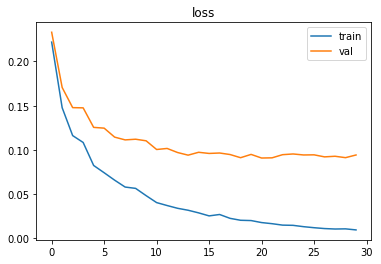

In [47]:
plt.title('loss')
plt.plot(loss, label='train')
plt.plot(loss_val, label='val')
plt.legend()

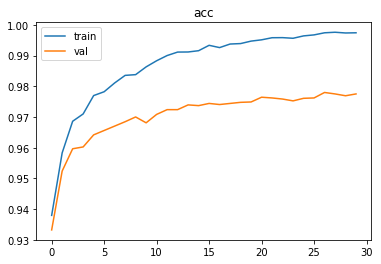

In [48]:
plt.title('acc')
plt.plot(accs, label='train')
plt.plot(accs_val, label='val')
plt.legend()

In [71]:
accs_val

[0.9332142857142857,
 0.9523809523809523,
 0.9596428571428571,
 0.9602380952380952,
 0.9641666666666666,
 0.9655952380952381,
 0.9670238095238095,
 0.968452380952381,
 0.97,
 0.9680952380952381,
 0.9708333333333333,
 0.9723809523809523,
 0.9723809523809523,
 0.9739285714285715,
 0.9736904761904762,
 0.9744047619047619,
 0.974047619047619,
 0.9744047619047619,
 0.9747619047619047,
 0.9748809523809524,
 0.9764285714285714,
 0.9761904761904762,
 0.9758333333333333,
 0.9752380952380952,
 0.9760714285714286,
 0.9761904761904762,
 0.9779761904761904,
 0.9775,
 0.9769047619047619,
 0.9775]

In [49]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_fin, net)